In [7]:
library(rlang)
library(repr)
library(tidyverse)
options(repr.plot.width=8, repr.plot.height=4)
library(xtable)
library(latex2exp)
library("dplyr")

In [165]:
# Data operations
group_data <- function(df, grouping_feature, group_size=25) {
    # Takes Sherpa dataframe and returns dataframe with 
    # Lambda (i.e. group), Group mean and Psi
    #
    # Args:
    #     df: Sherpa output dataframe.
    #     grouping_feature: feature to group by.
    #
    # Returns:
    #     tbl: Lambda (i.e. group), Group mean and Psi
    names(df)[names(df) == grouping_feature] <- 'grouping_feature'
    df <- as.tibble(df)
    grpdf <- df %>% group_by_at('grouping_feature') %>%
            summarise(mean=mean(Objective), count=n()) %>%
            filter(count==group_size) %>%
            arrange(mean) %>%
            mutate(Lambda = 1:n()) %>%
            inner_join(df, by='grouping_feature') %>%
            rename(Psi=Objective, Mean=mean) %>%
            select(Lambda, Psi)
    return(grpdf)
}

subsample_groups <- function(tbl, num_groups) {
    # Helper to subsample by hyperparameter setting (Lambda).
    #
    # Args:
    #     tbl: the dataframe/tibble
    #     num_groups: the number to subsample i.e. K
    #
    # Returns:
    #     The subsampled tibble.
    return(filter(tbl, Lambda %in% sample(unique(tbl$Lambda), num_groups, replace=F)))
}

subsample_trials <- function(tbl, num_trials, replace=F) {
    # Helper to subsample trials for the existing groups.
    #
    # Args:
    #     tbl: the dataframe/tibble
    #     num_trials: the number to subsample i.e. n_lambda
    #
    # Returns:
    #     The subsampled tibble.
    return(tbl %>% group_by(Lambda) %>% sample_n(num_trials, replace=replace))
}

add_trials <- function(tbl, newtbl) {
    # Helper to combine new trials with previous.
    #
    # Args:
    #     tbl: the dataframe/tibble with the previous trials.
    #     newtbl: the dataframe with the new trials.
    #
    # Returns:
    #     The joined tibble.
    return(full_join(tbl, newtbl, by=c("Lambda", "Psi")) %>%
           arrange(Lambda))
}

select_lambda_star <- function(tbl) {
    # Return the trials that have minimum observed mean.
    #
    # Args:
    #     tbl: the available trials.
    #
    # Returns:
    #     tibble that contains only trials from lambda star.
    return(tbl  %>% 
                group_by(Lambda) %>% 
                summarise(ObservedMean=mean(Psi)) %>% 
                arrange(ObservedMean) %>% 
                mutate(Rank=1:n()) %>% 
                inner_join(tbl, 'Lambda') %>% filter(Rank==1))
}

In [82]:
CalcPocockErrorAndSampleSize <- function (n, alpha){
    # Calculate the alpha dash values and sample size for interim analyses
    #
    # Args:
    #   n: vector of sample size at each analysis.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   A list containing alpha dash and the sample size at each analysis.
    if (length(n) > 1){
        if (length(n) == 3) {
            alpha.dash <- rep(0.02317456, 3)
        } else if (length(n) == 5) {
            alpha.dash <- rep(0.01693147, 5)
        } else {
            information.fraction <- n/max(n)
            spent.error <- alpha * log(1+(exp(1)-1)*information.fraction)
            alpha.dash <- c(spent.error[1], diff(spent.error))
        }
        n.delta <- c(n[1], diff(n))
    } else {
        alpha.dash <- alpha
        n.delta <- n
    }
    return(list(alpha.dash=alpha.dash, n.delta=n.delta))
}

filter_by_anova <- function(df, alpha=0.05, verbose=T) {
    # Binary Search ANOVA
    #
    # Args:
    #     df: available trials with grouping variable Lambda
    #     alpha: type I error level
    #     verbose: option for turn output on/off
    #
    # Returns:
    #     Tibble of found nullset.
    df <- df  %>% 
        group_by(Lambda) %>% 
        summarise(ObservedMean=mean(Psi)) %>% 
        arrange(ObservedMean) %>% 
        mutate(Rank=1:n()) %>% 
        inner_join(df, 'Lambda')
    K <- max(df$Rank)
    l <- 1
    h <- K
    p <- h
    count <- 1
    while(l != h){

        pval <- anova(lm(Psi ~ factor(Lambda), df, subset=Rank<=p))$'Pr(>F)'[1]
        reject <- pval < alpha/ceiling(log2(K)+1)
#         reject <- pval < alpha
        if (verbose) {
            cat(paste("Test ", count, "/", ceiling(log2(K)+1), "\n",
                      "l=",l," h=",h," p=",p,"\n",
                      ifelse(reject,"Reject", "Accept"), " (p-val=", pval, ")", "\n\n"
                      , sep=""))
        }
        if(reject){
            h <- p - 1
        } else {
            l <- p
        }
        p <- ceiling((l+h)/2)
        count <- count + 1
    }
    if (verbose) {cat(paste("l=",l," h=",h,"\n", sep=""))}
    return(filter(df, Rank<=l) %>% select(Lambda, Psi))
}


FilterTrials <- function(tbl, n.lambda, alpha=0.05) {
    # Testing procedure to generate nullset from candidates.
    #
    # Args:
    #   tbl: data frame containing all available trials
    #   n.lambda: vector of sample sizes for each interim analysis,
    #             also determines the number of analyses.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   Tibble containing trials in H0.
    pocock <- CalcPocockErrorAndSampleSize(n.lambda, alpha)
    alpha.dash <- pocock$alpha.dash
    n.lambda.delta <- pocock$n.delta
    num.trials <- 0
    
    # H and H0 denote indices with respect to psi
    for (i in 1:length(n.lambda)){
        new.trials <- subsample_trials(tbl, n.lambda.delta[i], replace=F)
        
        tbl <- anti_join(tbl, new.trials, by = c("Lambda", "Psi"))
        if (i > 1) {
            new.trials <- filter(new.trials, Lambda %in% unique(trials$Lambda))
            trials <- add_trials(trials, new.trials)
        } else {
            trials <- new.trials
        }
        num.trials <- num.trials + nrow(new.trials)
        
        if (n.lambda.delta[i]==1 && length(n.lambda.delta)==1) {
            trials <- filter(trials, Psi==min(trials$Psi))
        } else {
            trials <- filter_by_anova(trials, alpha=alpha.dash[i], verbose=F)
        }
    }
    return(list(H0=trials, num.trials=num.trials))
}

GetLambdaStarPopulation <- function(tbl, H0, sample=F) {
    if (length(unique(H0$Lambda)) > 1) {
        if (sample) {
                lambda.star.sample <- filter(tbl, Lambda==sample(unique(H0$Lambda), 1))
        } else {
            lambda.star.sample <- select_lambda_star(H0)
        }
    } else {
        lambda.star.sample <- H0
    }
    lambda.star.population <- filter(tbl, Lambda %in% unique(lambda.star.sample$Lambda))
    return(lambda.star.population)
}
TestGetLambdaStarPopulation <- function() {
    H0 <- FilterTrials(subsample_groups(mnist, 50), c(5), alpha=0.05)$H0
    print(unique(H0$Lambda)[1] == GetLambdaStarPopulation(mnist,H0,sample=F)$Lambda[1])
    print(GetLambdaStarPopulation(mnist,H0,sample=T)$Lambda[1] %in% unique(H0$Lambda))
}
TestGetLambdaStarPopulation()

plot_groups <- function(df, xlab="Loss") {
    # Helper to make quick plots of the groups.

    # Args:
    #     df: dataframe/tibble containing groups
    #         with at least a Lambda and Psi column.

    # Returns:
    #     Plot.
    p <- ggplot(df, aes(x=Psi, fill=factor(Lambda)))
    p <- p + geom_density(alpha=0.4)
    p <- p + labs(fill = "HP Setting", x=xlab, y="Density")
    return(p)
}

EvalMetrics <- function(tbl, n.lambda, alpha, num.runs, K, test.tbl=NULL) {
    # Function to evaluate metrics from results section 1.
    #
    # Args:
    #     tbl: all available trials.
    #     n.lambda: vector of sample sizes.
    #     alpha: type I error level
    #     num.runs: number of simulations
    #     K: number of candidate hyperparameter settings
    #     test.tbl: test results.
    #
    # Returns:
    #     List of metrics.
    H0.size <- rep(NA, num.runs)
    lambda.star.in.H0 <- rep(NA, num.runs)
    num.trials <- rep(NA, num.runs)
    rejection.power <- rep(NA, num.runs)
    epe.sampled <- rep(NA, num.runs)
    epe.best <- rep(NA, num.runs)
    for(i in 1:num.runs) {
        subsampleGroups <- subsample_groups(tbl, num_groups=K)
        rval <- FilterTrials(subsampleGroups, n.lambda=n.lambda, alpha=0.05)
        filteredTbl <- rval$H0
        
        num.trials[i] <- rval$num.trials
        H0.size[i] <- length(unique(filteredTbl$Lambda))
        lambda.star.in.H0[i] <- min(subsampleGroups$Lambda) %in% unique(filteredTbl$Lambda)
        rejection.power[i] <- (K - H0.size[i] - !lambda.star.in.H0[i])/(K-1)
        
        epe.sampled[i] <- mean(GetLambdaStarPopulation(tbl=tbl, H0=filteredTbl, sample=T)$Psi)
        epe.best[i] <- mean(GetLambdaStarPopulation(tbl=tbl, H0=filteredTbl, sample=F)$Psi)
    }
    
    return(list('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$'=mean(lambda.star.in.H0),
                '$\\bar{|\\mathcal{H}_0|}$'=mean(H0.size),
                '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$'=mean(rejection.power),
                'Avg Evaluations'=mean(num.trials),
                '$Mean[E(\\Psi(\\lambda^*))]$'=mean(epe.best),
                '$Var[E(\\Psi(\\lambda^*))]$'=var(epe.best),
                '$Mean[E(\\Psi(\\lambda^s))]$'=mean(epe.sampled),
                '$Var[E(\\Psi(\\lambda^s))]$'=var(epe.sampled)))
}

[1] TRUE
[1] TRUE


In [77]:
TableCreator <- function(results=NULL, caption="", label="") {
    cat(paste("\\begin{table}\n",
              "\\caption{", caption, "\\label{tab:", label, "}}\n",
              "\\begin{center}\n",
              "\\begin{tabular}{l", paste(rep("c", 5), sep="", collapse=""),"}\n",
              "\\toprule\n", sep=""))
    
    cat(paste(paste(c("$n_\\lambda$", names(results[[1]])), collapse=" & "), "\\\\\n"))
    
    for(K in names(results)){
        cat("\n\\midrule\n")
        cat(paste("$K=", K, "$", paste(rep("&", 5), sep="", collapse=""), "\\\\\n"))
        for(m in c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                '$\\bar{|\\mathcal{H}_0|}$',
                '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                'Avg Evaluations')){
            row <- NULL
            for(n in names(results[[K]])) {
                row <- c(row, as.character(round(results[[K]][[n]][[m]], 3)))
            }
            cat(paste(paste(c(m, row), collapse=" & "),"\\\\", "\n"))
        }   
    }
    cat(paste("\n\\bottomrule\n",
    "\\end{tabular}\n",
    "\\end{center}\n",
    "\\end{table}\n"))
    
}

# Type I Error

In [974]:
K <- 100
n <- 10
alpha <- 0.05
num.runs <- 1000
H0.size <- rep(NA, num.runs)
for(i in 1:num.runs){
    df <- as.tibble(data.frame(Psi=rnorm(K*n, mean=0, sd=1), Lambda=rep(1:K, each=n)))
    filtered.df <- filter_by_anova(df=df, alpha=alpha, verbose=F)
    H0.size[i] <- length(unique(filtered.df$Lambda))
}
mean(H0.size<K)
H0.size[which(H0.size<K)]

[1] 0.003

[1] 99 99 99

In [975]:
K <- 100
n <- 10
n.lambda <- c(3,6,9)
alpha <- 0.05
num.runs <- 1000
H0.size <- rep(NA, num.runs)
for(i in 1:num.runs){
    df <- as.tibble(data.frame(Psi=rnorm(K*n, mean=0, sd=1), Lambda=rep(1:K, each=n)))
    filtered.df <- FilterTrials(tbl=df, n.lambda=n.lambda, alpha=alpha)$H0
    H0.size[i] <- length(unique(filtered.df$Lambda))
}
mean(H0.size<K)
H0.size[which(H0.size<K)]

[1] 0.01

[1] 99 99 98 99 99 98 99 99 99 98

# Motivating Example

In [11]:
f <- function(x, sd=5){
    y <- (x-3)^2 + 10
    if(sd==0){
        return(y)
    }else{
        return(y + rnorm(length(x), mean=0, sd=sd))
    }
}

In [182]:
x <- seq(1, rlim-1, 0.5)
n<-10
X <- matrix(rep(x,each=n),nrow=n)

In [188]:
num.runs <- 1000
x.369 <- rep(NA, num.runs)
for(i in 1:num.runs){
    Y <- f(X, sd=2)
    colnames(Y) <- x
    toy.raw <- gather(as.data.frame(Y)) %>% rename(Objective=value, x=key)
    toy.df <- group_data(toy.raw, 'x', group_size=10)
    toy.result <- FilterTrials(toy.df, n.lambda=c(3,6,9))$H0 %>%
    select_lambda_star() %>%
    left_join(toy.raw %>% rename(Psi=Objective), by=c('Psi'))
    x.369[i] <- as.numeric(unique(toy.result$x))
}


In [189]:
num.runs <- 1000
x.1 <- rep(NA, num.runs)
for(i in 1:num.runs){
    Y <- f(X, sd=2)
    colnames(Y) <- x
    toy.raw <- gather(as.data.frame(Y)) %>% rename(Objective=value, x=key)
    toy.df <- group_data(toy.raw, 'x', group_size=10)
    toy.result <- FilterTrials(toy.df, n.lambda=c(1))$H0 %>%
    select_lambda_star() %>%
    left_join(toy.raw %>% rename(Psi=Objective), by=c('Psi'))
    x.1[i] <- as.numeric(unique(toy.result$x))
}


In [195]:
toy.hist.df <- data.frame(Method=factor(c(rep('1', length(x.1)), rep('3,6,9', length(x.369)))),
                          x=c(x.1, x.369))

In [203]:
toy.hist.df %>% group_by(Method) %>% summarise(Mean=mean(x), Var=var(x), Count=n())

Method,Mean,Var,Count
1,2.974,0.5608849,1000
"3,6,9",3.010,0.2211211,1000


In [200]:
# ggplot(toy.hist.df, aes(x=x, color=Method, fill=Method)) +
#   geom_histogram(alpha=0.7, position="identity", binwidth=0.5)

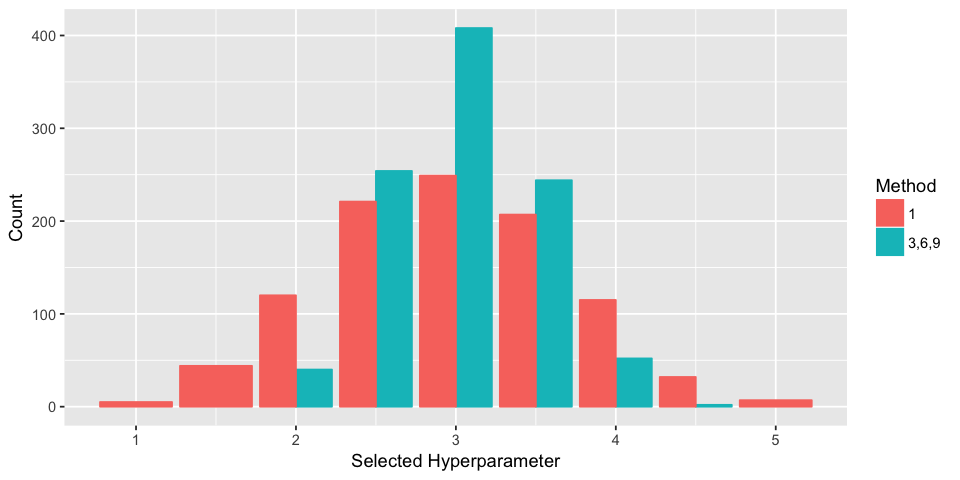

In [198]:
p <- ggplot(toy.hist.df, aes(x=x, color=Method, fill=Method)) + geom_bar(position="dodge") + labs(x="Selected Hyperparameter", y = "Count")
p

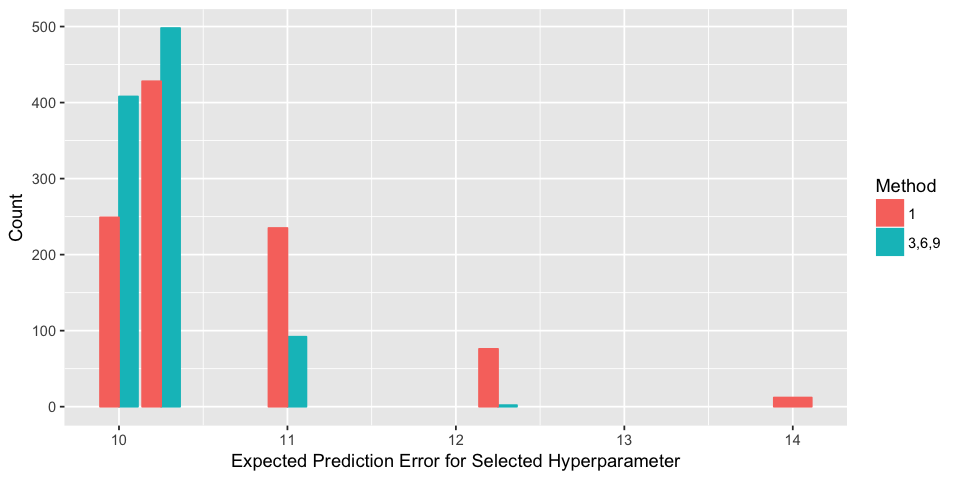

In [201]:
p <- ggplot(toy.hist.df, aes(x=f(x, sd=0), color=Method, fill=Method)) + geom_bar(position="dodge") + labs(x="Expected Prediction Error for Selected Hyperparameter", y = "Count")
p

# Definitions

In [985]:
K.values <- c(50, 100, 150)
n.lambda <- list('1'=c(1), '5'=c(5), '10'=c(10), '3,6,9'=c(3,6,9))
num.runs <- 1000

# MNIST

In [79]:
results <- read.csv("./mnistcnn/mnist_results.csv", header = T)
completed <- subset(results, Status == 'COMPLETED')
mnist <- group_data(completed, 'dropout')

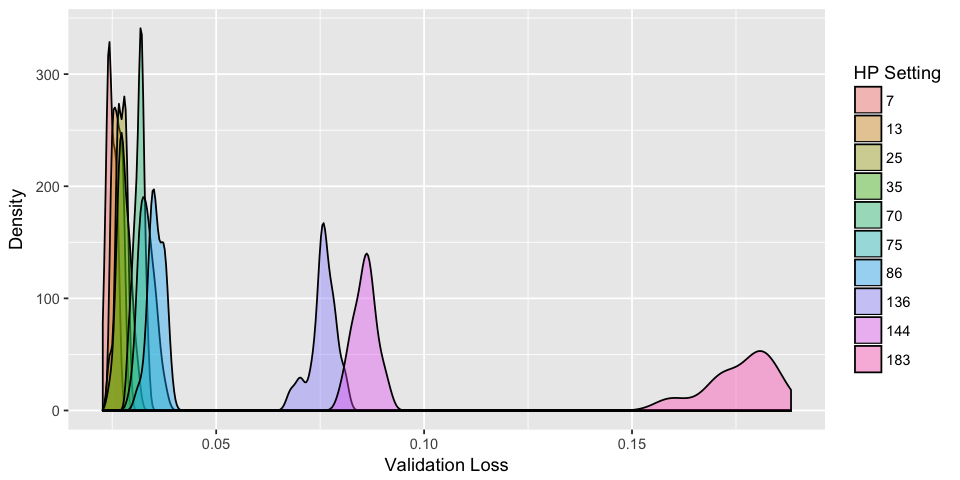

In [499]:
mnist.plot <- plot_groups(subsample_trials(subsample_groups(mnist, 10), 25), xlab="Validation Loss")
mnist.plot

In [ ]:
ggsave("figures/MNIST-density.pdf", plot=mnist.plot, width=8, height=4)

In [986]:
mnist.results <- list()
for(k in K.values) {
    mnist.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
#         cat(paste("Running K=", k, " n.lambda=", paste(as.character(n.lambda[[names(n.lambda)[i]]]), sep="", collapse=""), "\n"))
        mnist.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetrics(tbl=mnist,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=k)
    }
}
mnist.caption <- "Results for the MNIST Convolutional Neural Network hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(mnist.results, caption=mnist.caption, label="mnist-results")

\begin{table}
\caption{Results for the MNIST Convolutional Neural Network hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:mnist-results}}
\begin{center}
\begin{tabular}{lccccc}
\toprule
$n_\lambda$ & 1 & 5 & 10 & 3,6,9 \\

\midrule
$K= 50 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.53 & 1 & 1 & 1 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 5.53 & 3.164 & 3.345 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.99 & 0.908 & 0.956 & 0.952 \\ 
Avg Evaluations & 50 & 250 & 500 & 195.723 \\ 

\midrule
$K= 100 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.41 & 1 & 1 & 0.999 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 7.72 & 4.629 & 4.824 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.994 & 0.932 & 0.963 & 0.961 \\ 
Avg Evaluations & 100 & 500 & 1000 & 364.053 \\ 

\midrule
$K= 150 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.386 & 1 & 1 & 1 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 9.251 &

# IMDB

In [979]:
imdb.csv <- read.csv("./imdblstm//imdb_results.csv", header = T)
imdb.test.acc <- read.csv("./imdblstm//imdb_results_test.csv", header = T)
imdb.completed <- subset(imdb.csv, Status == 'COMPLETED')
imdb.completed$Objective <- 1.-imdb.completed$Objective+rnorm(nrow(imdb.completed), 0, 0.000000001)
imdb <- group_data(imdb.completed, 'dropout_embedding')

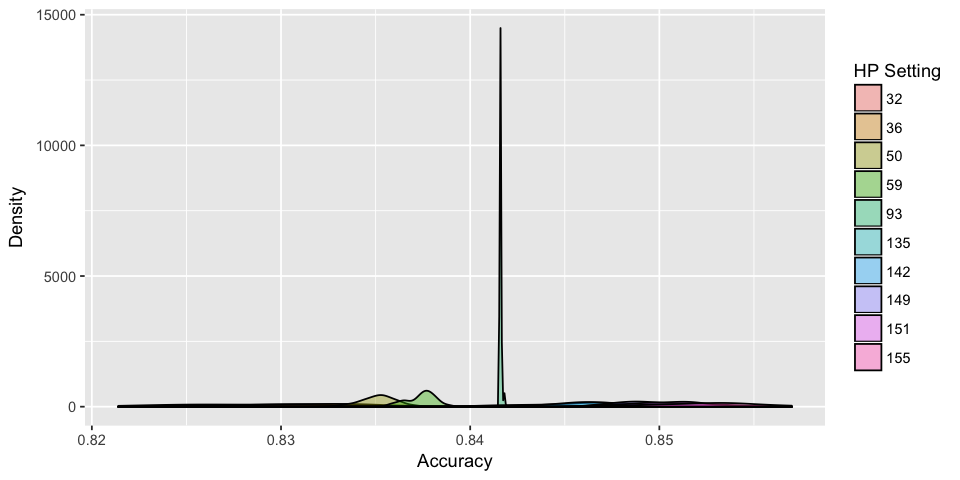

In [724]:
imdb.plot <- plot_groups(subsample_trials(subsample_groups(imdb, 10), 25), xlab="Accuracy")
imdb.plot

In [ ]:
# ggsave("figures/IMDB-density.pdf", plot=imdb.plot, width=8, height=4)

In [987]:
imdb.results <- list()
for(k in K.values) {
    imdb.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
        imdb.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetrics(tbl=imdb,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=k)
    }
}
imdb.caption <- "Results for the IMDB LSTM hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(imdb.results, caption=imdb.caption, label="imdb-results")

\begin{table}
\caption{Results for the IMDB LSTM hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:imdb-results}}
\begin{center}
\begin{tabular}{lccccc}
\toprule
$n_\lambda$ & 1 & 5 & 10 & 3,6,9 \\

\midrule
$K= 50 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.544 & 1 & 1 & 1 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 5.738 & 3.272 & 3.469 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.991 & 0.903 & 0.954 & 0.95 \\ 
Avg Evaluations & 50 & 250 & 500 & 196.683 \\ 

\midrule
$K= 100 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.353 & 1 & 0.999 & 1 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 8.265 & 4.96 & 5.172 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.993 & 0.927 & 0.96 & 0.958 \\ 
Avg Evaluations & 100 & 500 & 1000 & 366.726 \\ 

\midrule
$K= 150 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.35 & 1 & 1 & 0.999 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 10.402 & 7.194 & 7.315 \\ 
$

# Boston

In [929]:
boston.csv <- read.csv("./bostongbrt/boston_results.csv", header = T)
boston.completed <- subset(boston.csv, Status == 'COMPLETED')
boston.completed <- boston.completed[order(boston.completed$Trial.ID),]
boston <- group_data(boston.completed, 'subsample')

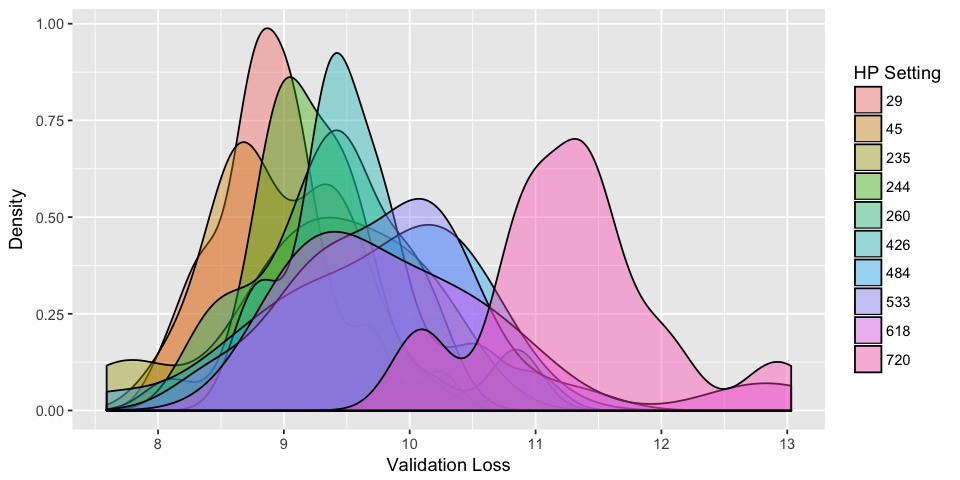

In [783]:
boston.plot <- plot_groups(subsample_trials(subsample_groups(boston, 10), 25), xlab="Validation Loss")
boston.plot

In [ ]:
# ggsave("figures/Boston-density.pdf", plot=boston.plot, width=8, height=4)

In [988]:
boston.results <- list()
for(k in K.values) {
    boston.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
        boston.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetrics(tbl=boston,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=k)
    }
}
boston.caption <- "Results for the Boston Housing gradient boosted regression tree hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(boston.results, caption=boston.caption, label="boston-results")

\begin{table}
\caption{Results for the Boston Housing gradient boosted regression tree hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:boston-results}}
\begin{center}
\begin{tabular}{lccccc}
\toprule
$n_\lambda$ & 1 & 5 & 10 & 3,6,9 \\

\midrule
$K= 50 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.072 & 1 & 1 & 1 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 38.784 & 30.985 & 33.095 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.981 & 0.229 & 0.388 & 0.345 \\ 
Avg Evaluations & 50 & 250 & 500 & 393.063 \\ 

\midrule
$K= 100 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.028 & 1 & 1 & 1 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 74.582 & 57.153 & 60.945 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.99 & 0.257 & 0.433 & 0.394 \\ 
Avg Evaluations & 100 & 500 & 1000 & 765.933 \\ 

\midrule
$K= 150 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.026 & 1 & 1 & 1 \\ 
$\bar{|\mathcal{H

# Cartpole

In [991]:
cartpole.csv <- read.csv("./cartpole/cartpole_results.csv", header = T)
cartpole.completed <- cartpole.csv[order(cartpole.csv$Trial.ID),]
cartpole.completed$Objective <- 1.-cartpole.completed$auc
cartpole <- group_data(cartpole.completed, 'gamma')

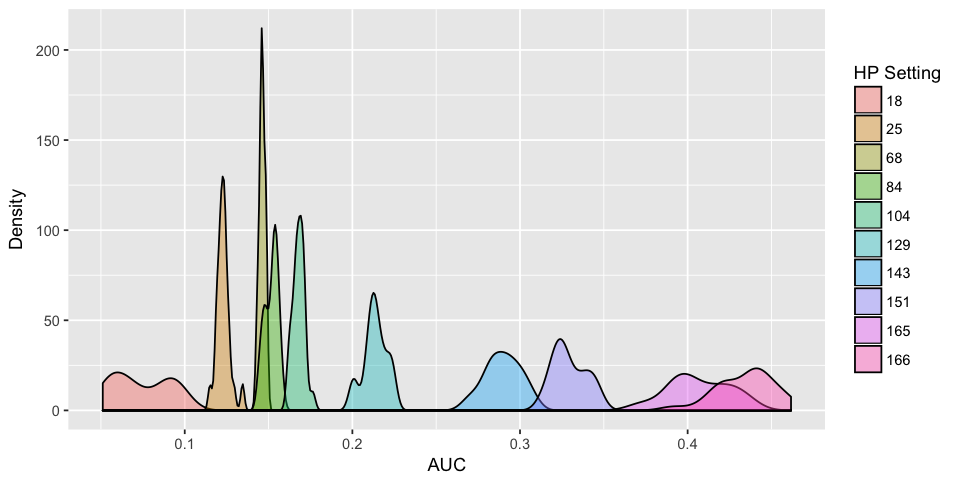

In [796]:
cartpole.plot <- plot_groups(subsample_trials(subsample_groups(cartpole, 10), 25), xlab="AUC")
cartpole.plot

In [ ]:
# ggsave("figures/Cartpole-density.pdf", plot=boston.plot, width=8, height=4)

In [992]:
cartpole.results <- list()
for(k in K.values) {
    cartpole.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
        cartpole.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetrics(tbl=cartpole,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=k)
    }
}
cartpole.caption <- "Results for the Cartpole PPO hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(cartpole.results, caption=cartpole.caption, label="cartpole-results")

\begin{table}
\caption{Results for the Cartpole PPO hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:cartpole-results}}
\begin{center}
\begin{tabular}{lccccc}
\toprule
$n_\lambda$ & 1 & 5 & 10 & 3,6,9 \\

\midrule
$K= 50 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.808 & 1 & 1 & 0.999 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 1.935 & 1.497 & 1.532 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.996 & 0.981 & 0.99 & 0.989 \\ 
Avg Evaluations & 50 & 250 & 500 & 163.938 \\ 

\midrule
$K= 100 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.728 & 1 & 1 & 0.999 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 2.739 & 1.755 & 1.813 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.997 & 0.982 & 0.992 & 0.992 \\ 
Avg Evaluations & 100 & 500 & 1000 & 320.607 \\ 

\midrule
$K= 150 $ &&&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.623 & 0.998 & 1 & 0.998 \\ 
$\bar{|\mathcal{H}_0|}$ & 1 & 3.413 & 1.

# Mean and Variance across repeated runs

In [1028]:
meanvar.num.runs <- 1000
meanvar.results <- list()
datasets <- list('Boston'=boston, 'MNIST'=mnist)
meanvar.K <- list('Boston'=c(50, 90), 'MNIST'=c(45))

In [1029]:
dataset.name <- 'MNIST'

meanvar.results[[dataset.name]] <- list()
for(k in meanvar.K[[dataset.name]]) {
    meanvar.results[[dataset.name]][[as.character(k)]] <- list()
    meanvar.results[[dataset.name]][[as.character(k)]][['3,6,9']] <- EvalMetrics(tbl=datasets[[dataset.name]],
                                                                n.lambda=c(3,6,9),
                                                                alpha=0.05,
                                                                num.runs=meanvar.num.runs,
                                                                K=k)
}

In [1030]:
adjusted.K <- list()
for (k in names(meanvar.results[[dataset.name]])) {
    adjusted.K[[k]] <- ceiling(meanvar.results[[dataset.name]][[k]][['3,6,9']][['Avg Evaluations']])
    cat(ifelse(adjusted.K[[k]] > length(unique(datasets[[dataset.name]]$Lambda)), "not enough trials", ""))
}

In [1031]:
for(k in meanvar.K[[dataset.name]]) {
    meanvar.results[[dataset.name]][[as.character(adjusted.K[[as.character(k)]])]] <- list()
    meanvar.results[[dataset.name]][[as.character(adjusted.K[[as.character(k)]])]][['1']] <- EvalMetrics(tbl=datasets[[dataset.name]],
                                                                                n.lambda=c(1),
                                                                                alpha=0.05,
                                                                                num.runs=meanvar.num.runs,
                                                                                K=adjusted.K[[as.character(k)]])
}

In [1032]:
meanvar.results[['MNIST']]

$`45`
$`45`$`3,6,9`
$`45`$`3,6,9`$`$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$`
[1] 1

$`45`$`3,6,9`$`$\\bar{|\\mathcal{H}_0|}$`
[1] 3.122

$`45`$`3,6,9`$`$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$`
[1] 0.9517727

$`45`$`3,6,9`$`Avg Evaluations`
[1] 177.429

$`45`$`3,6,9`$`$Mean[E(\\Psi(\\lambda^*))]$`
[1] 0.02410103

$`45`$`3,6,9`$`$Var[E(\\Psi(\\lambda^*))]$`
[1] 5.665793e-07

$`45`$`3,6,9`$`$Mean[E(\\Psi(\\lambda^s))]$`
[1] 0.02459688

$`45`$`3,6,9`$`$Var[E(\\Psi(\\lambda^s))]$`
[1] 1.136022e-06



$`178`
$`178`$`1`
$`178`$`1`$`$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$`
[1] 0.369

$`178`$`1`$`$\\bar{|\\mathcal{H}_0|}$`
[1] 1

$`178`$`1`$`$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$`
[1] 0.996435

$`178`$`1`$`Avg Evaluations`
[1] 178

$`178`$`1`$`$Mean[E(\\Psi(\\lambda^*))]$`
[1] 0.02396218

$`178`$`1`$`$Var[E(\\Psi(\\lambda^*))]$`
[1] 5.425535e-07

$`178`$`1`$`$Mean[E(\\Psi(\\lambda^s))]$`
[1] 0.02396218

$`178`$`1`$`$Var[E(\\Psi(\\lambda^s))]$`
[1] 5.425535e-07